# Earnings Strangle Strategy Analysis
## Selling 20-Delta Strangles Before Earnings

### Strategy Overview

**The Setup:**
- **Entry Time:** 3:50 PM ET on the day before earnings announcement
- **Exit Time:** 9:45 AM ET the next morning (after earnings)
- **Position:** Sell strangle (short OTM call + short OTM put)
- **Strike Selection:** 20-delta options on both sides
- **DTE:** Shortest available expiration (typically 0-1 DTE)

### The Thesis

This strategy attempts to capture **implied volatility crush** after earnings. Before earnings, options trade at elevated IV due to uncertainty. After the announcement, IV collapses rapidly, allowing traders to profit from time decay and vega losses—even if the stock moves moderately.

### The Reality Check

While the concept is appealing, this analysis reveals a critical flaw: **fat-tailed distributions and occasional large losses can completely erase many small gains**. The strategy suffers from negative skewness—collecting pennies in front of the proverbial steamroller.

Let's dive into the data to understand why this edge may be illusory.

In [1]:
# Import necessary libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load and Parse Data

In [2]:
# Load the JSON data
with open(r'c:\Users\Naeem\Downloads\Selling Strangle before Earnings.json', 'r') as f:
    data = json.load(f)

print(f"Data loaded successfully!")
print(f"Number of rolling windows: {len(data['rollingWindow'])}")

Data loaded successfully!
Number of rolling windows: 232


In [6]:
# Extract trade statistics from each rolling window
results = []

for period, window_data in data['rollingWindow'].items():
    trade_stats = window_data['tradeStatistics']
    portfolio_stats = window_data['portfolioStatistics']
    
    results.append({
        'period': period,
        'start_date': trade_stats['startDateTime'],
        'end_date': trade_stats['endDateTime'],
        'total_trades': int(trade_stats['totalNumberOfTrades']),
        'winning_trades': int(trade_stats['numberOfWinningTrades']),
        'losing_trades': int(trade_stats['numberOfLosingTrades']),
        'total_pnl': float(trade_stats['totalProfitLoss']),
        'total_profit': float(trade_stats['totalProfit']),
        'total_loss': float(trade_stats['totalLoss']),
        'largest_profit': float(trade_stats['largestProfit']),
        'largest_loss': float(trade_stats['largestLoss']),
        'avg_pnl': float(trade_stats['averageProfitLoss']),
        'avg_profit': float(trade_stats['averageProfit']),
        'avg_loss': float(trade_stats['averageLoss']) if trade_stats['averageLoss'] != '0' else 0,
        'win_rate': float(trade_stats['winRate']),
        'loss_rate': float(trade_stats['lossRate']),
        'profit_factor': float(trade_stats['profitFactor']) if trade_stats['profitFactor'] != '0' else 0,
        'sharpe_ratio': float(trade_stats['sharpeRatio']),
        'max_drawdown': float(trade_stats['maximumClosedTradeDrawdown']),
        'max_intra_drawdown': float(trade_stats['maximumIntraTradeDrawdown']),
        'pnl_std': float(trade_stats['profitLossStandardDeviation']),
        'total_fees': float(trade_stats['totalFees']),
        'compounding_annual_return': float(portfolio_stats['compoundingAnnualReturn']),
        'portfolio_sharpe': float(portfolio_stats['sharpeRatio'])
    })

df = pd.DataFrame(results)
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

# Remove rows with invalid dates
df = df.dropna(subset=['start_date', 'end_date'])

print(f"\nDataFrame created with {len(df)} periods")
print(f"Date range: {df['start_date'].min()} to {df['end_date'].max()}")
df.head()


DataFrame created with 227 periods
Date range: 2021-01-06 20:50:00+00:00 to 2025-10-31 13:45:00+00:00


,period,start_date,end_date,total_trades,winning_trades,losing_trades,total_pnl,total_profit,total_loss,largest_profit,...,win_rate,loss_rate,profit_factor,sharpe_ratio,max_drawdown,max_intra_drawdown,pnl_std,total_fees,compounding_annual_return,portfolio_sharpe
0,M1_20210131,2021-01-06 20:50:00+00:00,2021-01-26 14:45:00+00:00,8,4,4,350.0,356.0,-6.0,260.0,...,0.5000,0.5000,59.3333,0.4871,-6.0,-306.0,89.8089,18.4,0.0411,3.0376
1,M1_20210228,2021-02-08 20:50:00+00:00,2021-02-24 14:45:00+00:00,4,4,0,362.0,362.0,0.0,187.0,...,1.0000,0.0000,10.0000,1.2958,0.0,-206.0,69.8403,8.0,0.0488,3.7937
2,M1_20210331,2021-03-15 19:50:00+00:00,2021-03-31 13:45:00+00:00,6,4,2,26.0,121.0,-95.0,61.0,...,0.6667,0.3333,1.2737,0.0852,-86.0,-115.0,50.8632,12.0,0.0017,-1.1716
3,M1_20210430,2021-04-27 19:50:00+00:00,2021-04-28 13:45:00+00:00,2,1,1,45.0,210.0,-165.0,210.0,...,0.5000,0.5000,1.2727,0.0849,-165.0,-252.0,265.1650,7.8,0.0046,0.4001
4,M1_20210531,2021-05-06 19:50:00+00:00,2021-05-11 13:45:00+00:00,4,2,2,163.0,221.0,-58.0,165.0,...,0.5000,0.5000,3.8103,0.4289,-58.0,-226.5,95.0136,11.8,0.0184,1.9639


## 2. Overall Performance Summary

In [7]:
# Calculate aggregate statistics
total_trades = df['total_trades'].sum()
total_winning = df['winning_trades'].sum()
total_losing = df['losing_trades'].sum()
total_pnl_cum = df['total_pnl'].sum()
total_profit_cum = df['total_profit'].sum()
total_loss_cum = df['total_loss'].sum()
overall_win_rate = total_winning / total_trades if total_trades > 0 else 0
overall_profit_factor = abs(total_profit_cum / total_loss_cum) if total_loss_cum != 0 else float('inf')

print("="*60)
print("OVERALL STRATEGY PERFORMANCE")
print("="*60)
print(f"\nTotal Trades: {total_trades}")
print(f"Winning Trades: {total_winning} ({overall_win_rate:.1%})")
print(f"Losing Trades: {total_losing} ({(1-overall_win_rate):.1%})")
print(f"\nCumulative P&L: ${total_pnl_cum:,.2f}")
print(f"Total Profits: ${total_profit_cum:,.2f}")
print(f"Total Losses: ${total_loss_cum:,.2f}")
print(f"\nProfit Factor: {overall_profit_factor:.2f}")
print(f"Average P&L per Trade: ${df['avg_pnl'].mean():,.2f}")
print(f"Average Win: ${df['avg_profit'].mean():,.2f}")
print(f"Average Loss: ${df['avg_loss'].mean():,.2f}")
print(f"\nLargest Single Win: ${df['largest_profit'].max():,.2f}")
print(f"Largest Single Loss: ${df['largest_loss'].min():,.2f}")
print(f"\nAverage Sharpe Ratio: {df['sharpe_ratio'].mean():.2f}")
print(f"Max Drawdown: ${df['max_drawdown'].min():,.2f}")
print("="*60)

OVERALL STRATEGY PERFORMANCE

Total Trades: 8800
Winning Trades: 5260 (59.8%)
Losing Trades: 3540 (40.2%)

Cumulative P&L: $-348,608.00
Total Profits: $774,904.00
Total Losses: $-1,123,512.00

Profit Factor: 0.69
Average P&L per Trade: $-19.83
Average Win: $141.85
Average Loss: $-275.74

Largest Single Win: $1,290.00
Largest Single Loss: $-7,900.00

Average Sharpe Ratio: 0.11
Max Drawdown: $-17,549.00


## 3. P&L Distribution Analysis

This is where the strategy's fatal flaw becomes apparent. Let's visualize the distribution of trade outcomes.

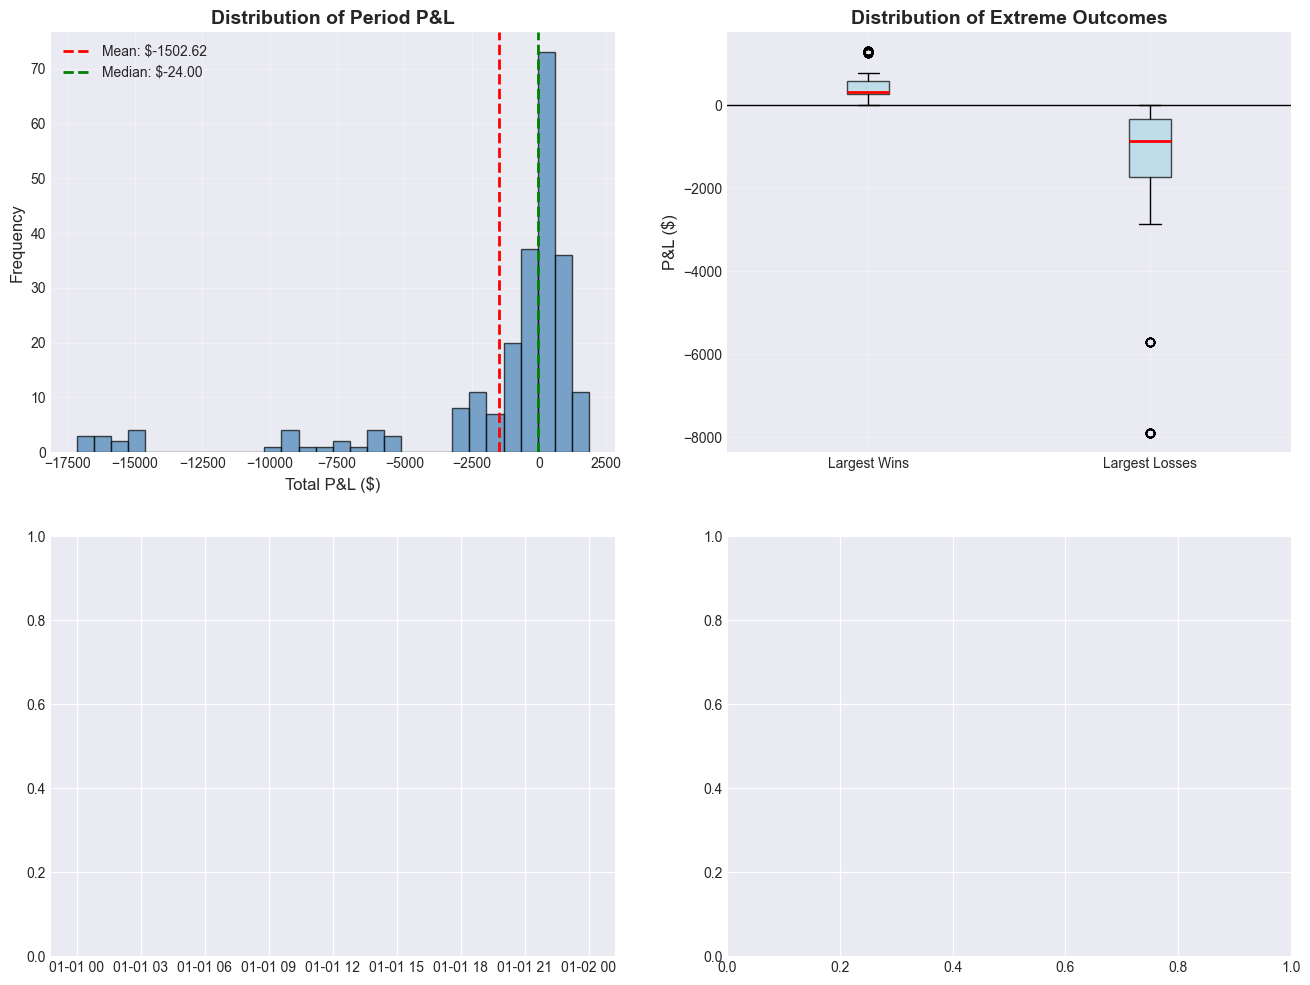

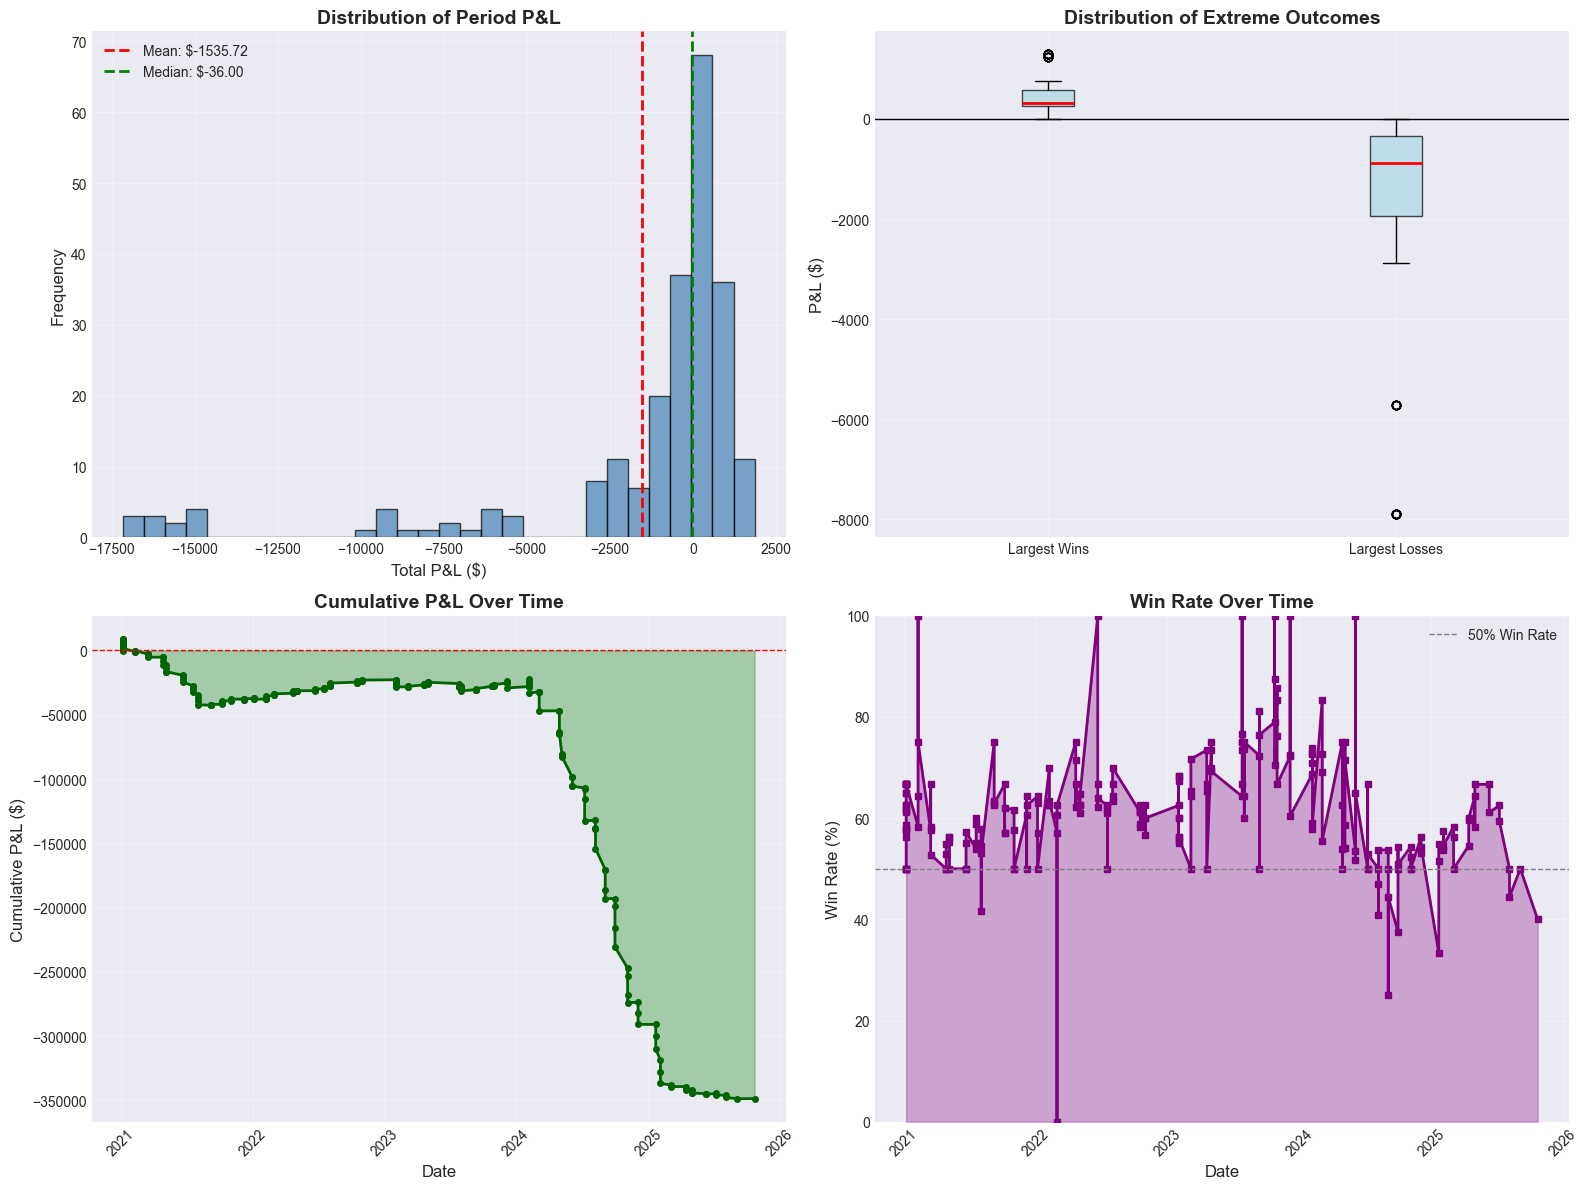

In [8]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram of Total P&L by Period
axes[0, 0].hist(df['total_pnl'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(df['total_pnl'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${df["total_pnl"].mean():.2f}')
axes[0, 0].axvline(df['total_pnl'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${df["total_pnl"].median():.2f}')
axes[0, 0].set_xlabel('Total P&L ($)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Period P&L', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot of wins vs losses
win_loss_data = []
for _, row in df.iterrows():
    if row['winning_trades'] > 0:
        win_loss_data.extend([row['avg_profit']] * int(row['winning_trades']))
    if row['losing_trades'] > 0:
        win_loss_data.extend([row['avg_loss']] * int(row['losing_trades']))

axes[0, 1].boxplot([df['largest_profit'], df['largest_loss']], 
                   labels=['Largest Wins', 'Largest Losses'],
                   patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
axes[0, 1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[0, 1].set_ylabel('P&L ($)', fontsize=12)
axes[0, 1].set_title('Distribution of Extreme Outcomes', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Cumulative P&L over time
df_sorted = df.sort_values('start_date')
df_sorted['cumulative_pnl'] = df_sorted['total_pnl'].cumsum()
axes[1, 0].plot(df_sorted['start_date'], df_sorted['cumulative_pnl'], linewidth=2, marker='o', markersize=4, color='darkgreen')
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1, 0].fill_between(df_sorted['start_date'], 0, df_sorted['cumulative_pnl'], alpha=0.3, color='green')
axes[1, 0].set_xlabel('Date', fontsize=12)
axes[1, 0].set_ylabel('Cumulative P&L ($)', fontsize=12)
axes[1, 0].set_title('Cumulative P&L Over Time', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Win rate over time
axes[1, 1].plot(df_sorted['start_date'], df_sorted['win_rate'] * 100, linewidth=2, marker='s', markersize=4, color='purple')
axes[1, 1].axhline(50, color='gray', linestyle='--', linewidth=1, label='50% Win Rate')
axes[1, 1].fill_between(df_sorted['start_date'], 0, df_sorted['win_rate'] * 100, alpha=0.3, color='purple')
axes[1, 1].set_xlabel('Date', fontsize=12)
axes[1, 1].set_ylabel('Win Rate (%)', fontsize=12)
axes[1, 1].set_title('Win Rate Over Time', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 100])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Fat Tail Analysis

Let's quantify the skewness and kurtosis to understand the distribution's tails.

In [9]:
# Calculate skewness and kurtosis
pnl_skewness = stats.skew(df['total_pnl'])
pnl_kurtosis = stats.kurtosis(df['total_pnl'])

print("="*60)
print("FAT TAIL ANALYSIS")
print("="*60)
print(f"\nSkewness: {pnl_skewness:.3f}")
if pnl_skewness < -0.5:
    print("  ⚠️  NEGATIVE SKEW - More frequent large losses than large gains")
elif pnl_skewness > 0.5:
    print("  ✓ POSITIVE SKEW - More frequent large gains than large losses")
else:
    print("  → ROUGHLY SYMMETRIC distribution")

print(f"\nKurtosis (Excess): {pnl_kurtosis:.3f}")
if pnl_kurtosis > 1:
    print("  ⚠️  FAT TAILS - Extreme events more common than normal distribution")
elif pnl_kurtosis < -1:
    print("  → THIN TAILS - Extreme events less common than normal distribution")
else:
    print("  → NORMAL-LIKE tails")

# Risk metrics
avg_win_size = df['avg_profit'].mean()
avg_loss_size = abs(df['avg_loss'].mean())
win_loss_ratio = avg_win_size / avg_loss_size if avg_loss_size > 0 else float('inf')

print(f"\n{'='*60}")
print("RISK/REWARD PROFILE")
print("="*60)
print(f"\nAverage Win Size: ${avg_win_size:.2f}")
print(f"Average Loss Size: ${avg_loss_size:.2f}")
print(f"Win/Loss Ratio: {win_loss_ratio:.2f}")
print(f"\nRequired Win Rate for Breakeven: {(1 / (1 + win_loss_ratio)):.1%}")
print(f"Actual Win Rate: {overall_win_rate:.1%}")

# Calculate how many wins are needed to recover from worst loss
worst_loss = df['largest_loss'].min()
trades_to_recover = abs(worst_loss) / avg_win_size if avg_win_size > 0 else float('inf')
print(f"\nWorst Single Loss: ${worst_loss:.2f}")
print(f"Wins Needed to Recover from Worst Loss: {trades_to_recover:.1f}")
print("="*60)

FAT TAIL ANALYSIS

Skewness: -2.601
  ⚠️  NEGATIVE SKEW - More frequent large losses than large gains

Kurtosis (Excess): 6.166
  ⚠️  FAT TAILS - Extreme events more common than normal distribution

RISK/REWARD PROFILE

Average Win Size: $141.85
Average Loss Size: $275.74
Win/Loss Ratio: 0.51

Required Win Rate for Breakeven: 66.0%
Actual Win Rate: 59.8%

Worst Single Loss: $-7900.00
Wins Needed to Recover from Worst Loss: 55.7


## 5. Detailed P&L Distribution Visualization

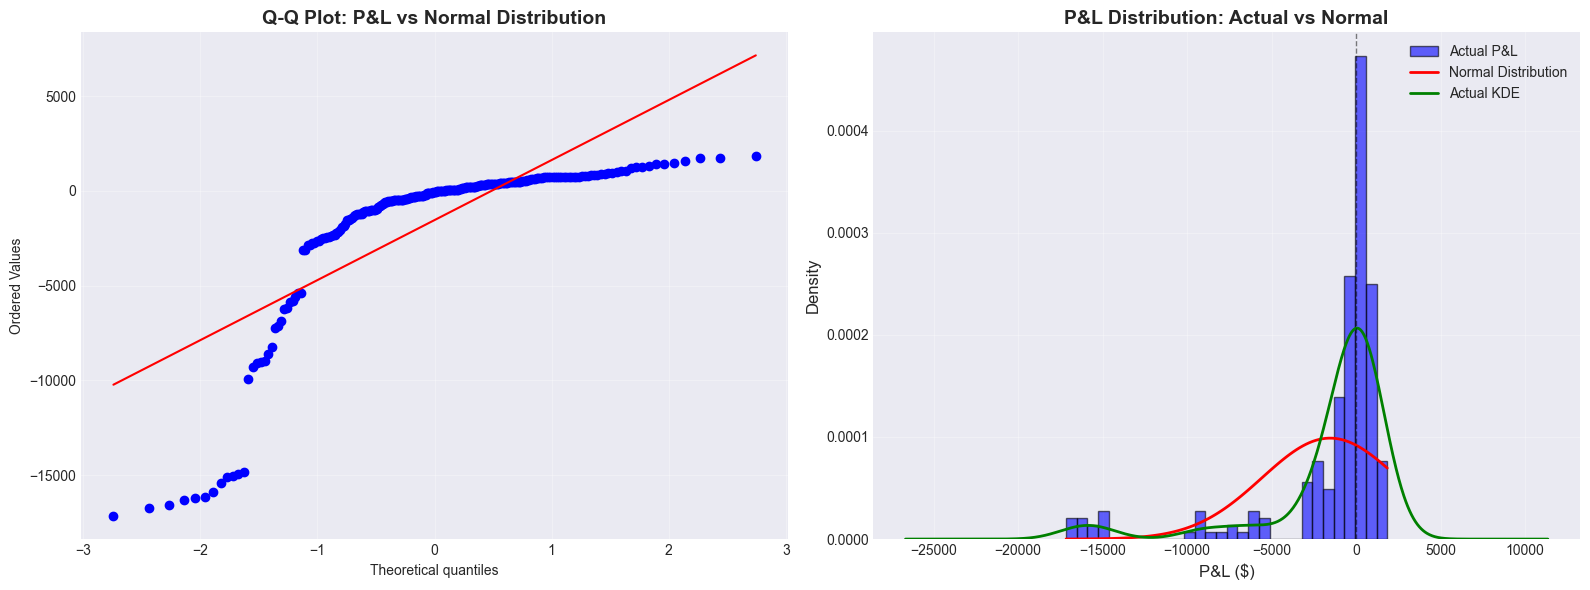


📊 Interpretation:
If the Q-Q plot deviates from the red line, especially in the tails,
it indicates the P&L distribution has fatter tails than a normal distribution.
This means extreme losses are more likely than a Gaussian model would predict.


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Q-Q Plot to check normality
stats.probplot(df['total_pnl'], dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot: P&L vs Normal Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. Kernel Density Estimate with normal overlay
axes[1].hist(df['total_pnl'], bins=30, density=True, alpha=0.6, color='blue', edgecolor='black', label='Actual P&L')

# Fit a normal distribution
mu, std = df['total_pnl'].mean(), df['total_pnl'].std()
x = np.linspace(df['total_pnl'].min(), df['total_pnl'].max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, std), 'r-', linewidth=2, label='Normal Distribution')

# Add KDE
df['total_pnl'].plot(kind='kde', ax=axes[1], linewidth=2, color='green', label='Actual KDE')

axes[1].axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('P&L ($)', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('P&L Distribution: Actual vs Normal', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("If the Q-Q plot deviates from the red line, especially in the tails,")
print("it indicates the P&L distribution has fatter tails than a normal distribution.")
print("This means extreme losses are more likely than a Gaussian model would predict.")

## 6. Trade Outcome Frequency Analysis

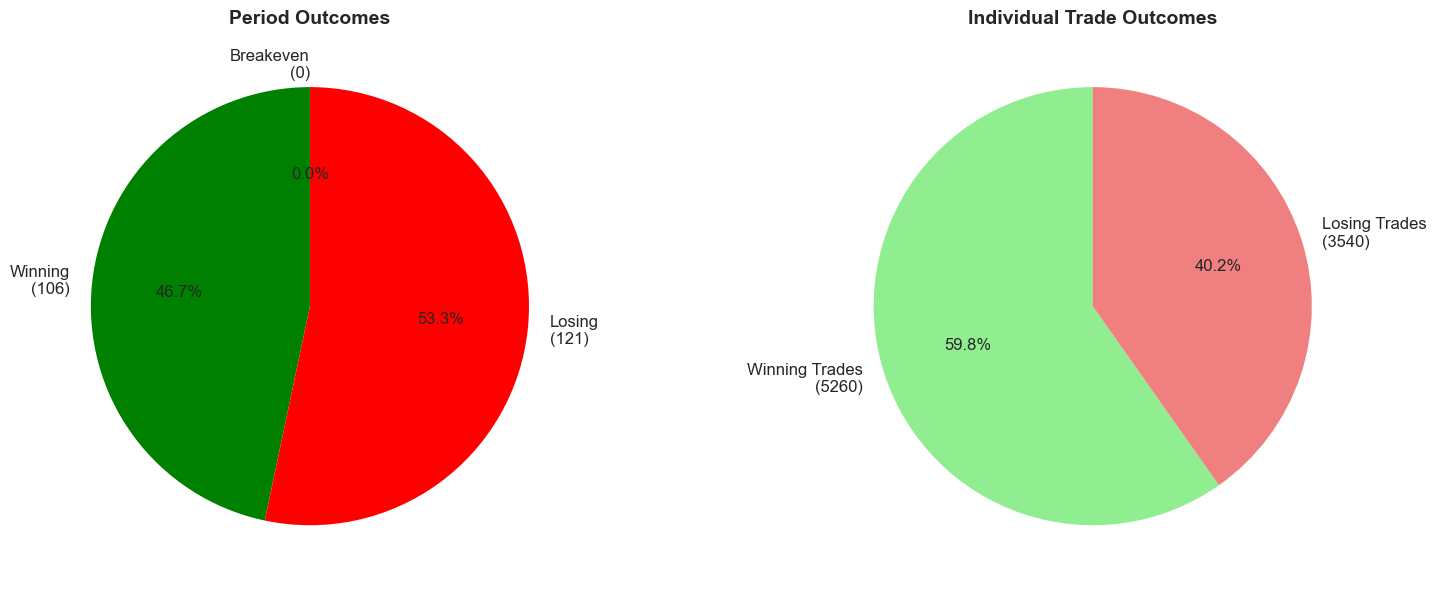


Period Performance:
  Winning Periods: 106/227 (46.7%)
  Losing Periods: 121/227 (53.3%)


In [11]:
# Count periods by performance
winning_periods = len(df[df['total_pnl'] > 0])
losing_periods = len(df[df['total_pnl'] < 0])
breakeven_periods = len(df[df['total_pnl'] == 0])

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Period outcomes
period_data = [winning_periods, losing_periods, breakeven_periods]
period_labels = [f'Winning\n({winning_periods})', f'Losing\n({losing_periods})', f'Breakeven\n({breakeven_periods})']
colors = ['green', 'red', 'gray']
axes[0].pie(period_data, labels=period_labels, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 12})
axes[0].set_title('Period Outcomes', fontsize=14, fontweight='bold')

# Trade outcomes
trade_data = [total_winning, total_losing]
trade_labels = [f'Winning Trades\n({total_winning})', f'Losing Trades\n({total_losing})']
axes[1].pie(trade_data, labels=trade_labels, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'], startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Individual Trade Outcomes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nPeriod Performance:")
print(f"  Winning Periods: {winning_periods}/{len(df)} ({winning_periods/len(df):.1%})")
print(f"  Losing Periods: {losing_periods}/{len(df)} ({losing_periods/len(df):.1%})")

## 7. Risk-Adjusted Returns

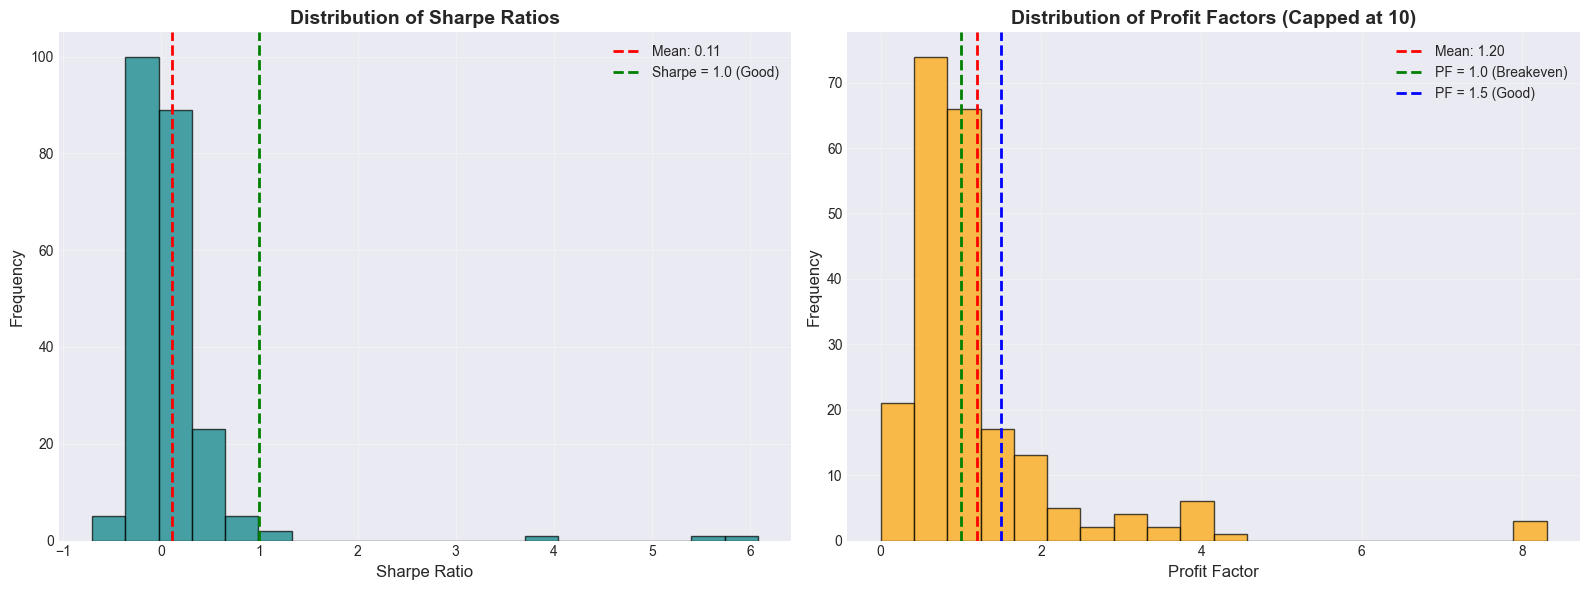


📈 Risk-Adjusted Metrics:
  Average Sharpe Ratio: 0.11
  Median Sharpe Ratio: -0.01
  % Periods with Sharpe > 1.0: 2.2%

  Average Profit Factor: 4.03
  Median Profit Factor: 0.96


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sharpe Ratio distribution
axes[0].hist(df['sharpe_ratio'], bins=20, edgecolor='black', alpha=0.7, color='teal')
axes[0].axvline(df['sharpe_ratio'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["sharpe_ratio"].mean():.2f}')
axes[0].axvline(1.0, color='green', linestyle='--', linewidth=2, label='Sharpe = 1.0 (Good)')
axes[0].set_xlabel('Sharpe Ratio', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Sharpe Ratios', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Profit Factor distribution
profit_factors = df[df['profit_factor'] < 10]['profit_factor']  # Remove outliers for visualization
axes[1].hist(profit_factors, bins=20, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(profit_factors.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {profit_factors.mean():.2f}')
axes[1].axvline(1.0, color='green', linestyle='--', linewidth=2, label='PF = 1.0 (Breakeven)')
axes[1].axvline(1.5, color='blue', linestyle='--', linewidth=2, label='PF = 1.5 (Good)')
axes[1].set_xlabel('Profit Factor', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Profit Factors (Capped at 10)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Risk-Adjusted Metrics:")
print(f"  Average Sharpe Ratio: {df['sharpe_ratio'].mean():.2f}")
print(f"  Median Sharpe Ratio: {df['sharpe_ratio'].median():.2f}")
print(f"  % Periods with Sharpe > 1.0: {(df['sharpe_ratio'] > 1.0).sum() / len(df):.1%}")
print(f"\n  Average Profit Factor: {df['profit_factor'].mean():.2f}")
print(f"  Median Profit Factor: {df['profit_factor'].median():.2f}")

## 8. Drawdown Analysis

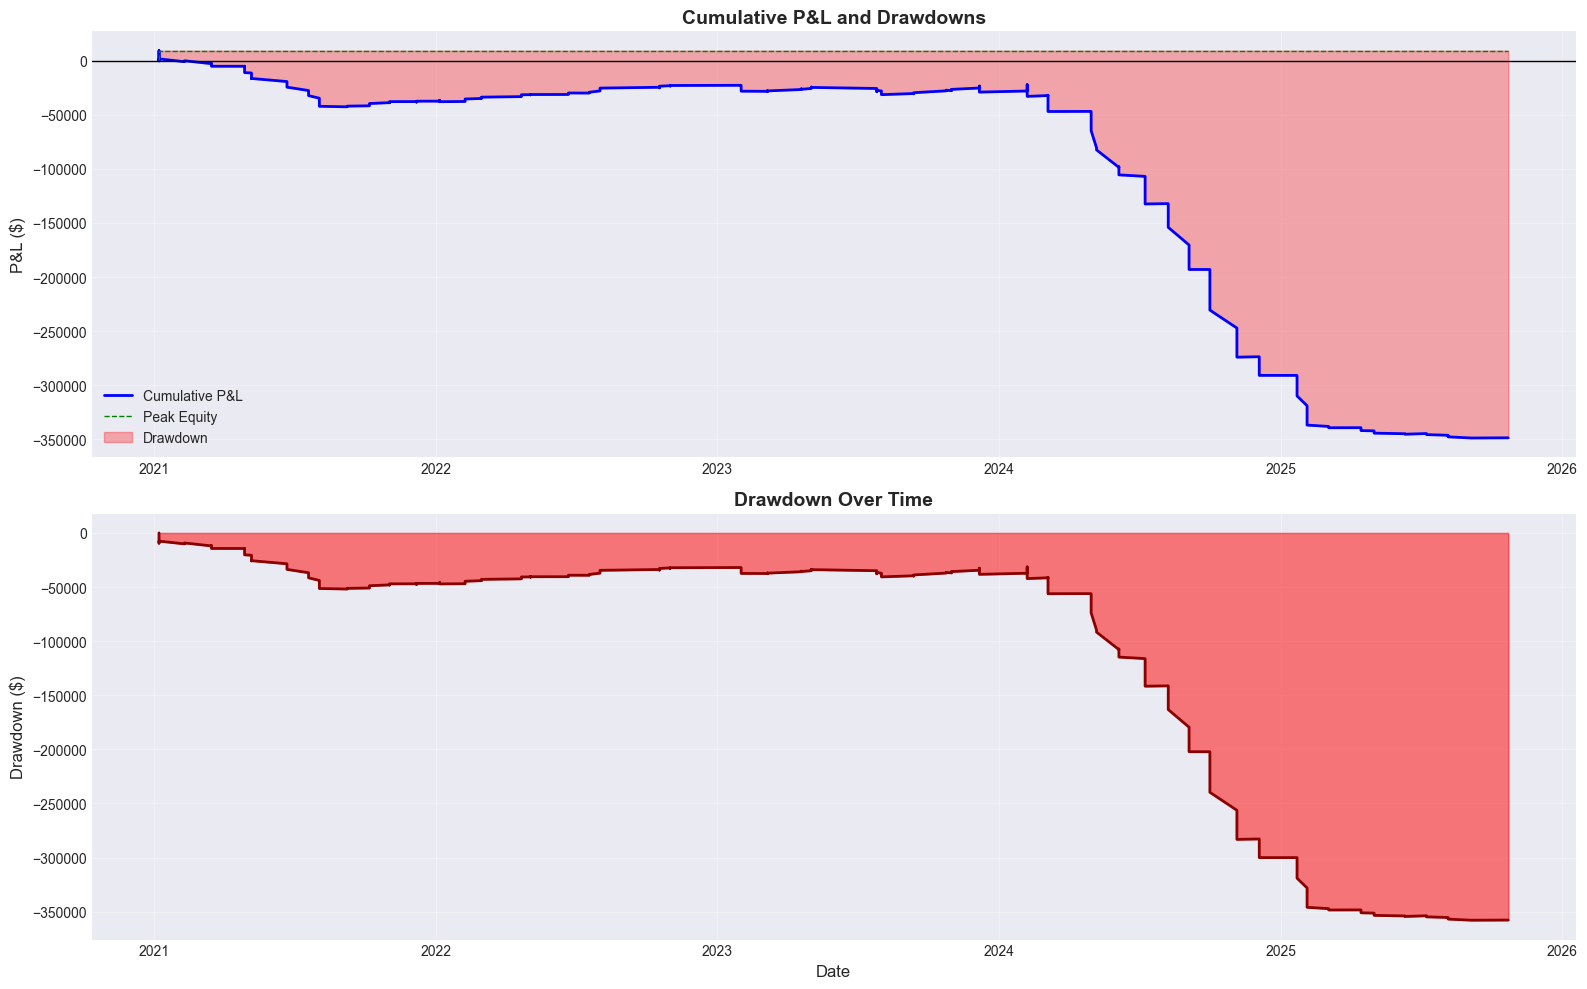


📉 Maximum Drawdown: $-357,947.00
   Occurred around: 2025-09-04


In [13]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Cumulative P&L with drawdowns highlighted
df_sorted = df.sort_values('start_date')
df_sorted['cumulative_pnl'] = df_sorted['total_pnl'].cumsum()
df_sorted['peak'] = df_sorted['cumulative_pnl'].cummax()
df_sorted['drawdown'] = df_sorted['cumulative_pnl'] - df_sorted['peak']

axes[0].plot(df_sorted['start_date'], df_sorted['cumulative_pnl'], linewidth=2, label='Cumulative P&L', color='blue')
axes[0].plot(df_sorted['start_date'], df_sorted['peak'], linewidth=1, linestyle='--', label='Peak Equity', color='green')
axes[0].fill_between(df_sorted['start_date'], df_sorted['cumulative_pnl'], df_sorted['peak'], 
                     where=df_sorted['drawdown'] < 0, alpha=0.3, color='red', label='Drawdown')
axes[0].axhline(0, color='black', linestyle='-', linewidth=1)
axes[0].set_ylabel('P&L ($)', fontsize=12)
axes[0].set_title('Cumulative P&L and Drawdowns', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Drawdown percentage over time
axes[1].fill_between(df_sorted['start_date'], 0, df_sorted['drawdown'], color='red', alpha=0.5)
axes[1].plot(df_sorted['start_date'], df_sorted['drawdown'], linewidth=2, color='darkred')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Drawdown ($)', fontsize=12)
axes[1].set_title('Drawdown Over Time', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

max_dd = df_sorted['drawdown'].min()
max_dd_date = df_sorted[df_sorted['drawdown'] == max_dd]['start_date'].values[0]
print(f"\n📉 Maximum Drawdown: ${max_dd:,.2f}")
print(f"   Occurred around: {pd.to_datetime(max_dd_date).strftime('%Y-%m-%d')}")

## 9. Statistical Summary Table

In [14]:
# Create comprehensive summary statistics
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Periods Analyzed',
        'Total Trades Executed',
        'Overall Win Rate',
        'Average Win',
        'Average Loss',
        'Largest Win',
        'Largest Loss',
        'Win/Loss Ratio',
        'Profit Factor',
        'Total Net P&L',
        'Avg P&L per Period',
        'Avg P&L per Trade',
        'Sharpe Ratio (avg)',
        'Max Drawdown',
        'Skewness',
        'Kurtosis (Excess)',
        'Std Dev of P&L'
    ],
    'Value': [
        f"{len(df)}",
        f"{total_trades}",
        f"{overall_win_rate:.1%}",
        f"${avg_win_size:,.2f}",
        f"${avg_loss_size:,.2f}",
        f"${df['largest_profit'].max():,.2f}",
        f"${df['largest_loss'].min():,.2f}",
        f"{win_loss_ratio:.2f}",
        f"{overall_profit_factor:.2f}",
        f"${total_pnl_cum:,.2f}",
        f"${df['total_pnl'].mean():,.2f}",
        f"${df['avg_pnl'].mean():,.2f}",
        f"{df['sharpe_ratio'].mean():.2f}",
        f"${df['max_drawdown'].min():,.2f}",
        f"{pnl_skewness:.3f}",
        f"{pnl_kurtosis:.3f}",
        f"${df['total_pnl'].std():,.2f}"
    ]
})

print("\n" + "="*60)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*60)
print(summary_stats.to_string(index=False))
print("="*60)


COMPREHENSIVE PERFORMANCE SUMMARY
                Metric        Value
Total Periods Analyzed          227
 Total Trades Executed         8800
      Overall Win Rate        59.8%
           Average Win      $141.85
          Average Loss      $275.74
           Largest Win    $1,290.00
          Largest Loss   $-7,900.00
        Win/Loss Ratio         0.51
         Profit Factor         0.69
         Total Net P&L $-348,608.00
    Avg P&L per Period   $-1,535.72
     Avg P&L per Trade      $-19.83
    Sharpe Ratio (avg)         0.11
          Max Drawdown  $-17,549.00
              Skewness       -2.601
     Kurtosis (Excess)        6.166
        Std Dev of P&L    $4,034.57


## 10. Conclusion: Why This Strategy Struggles

### The Fatal Flaws:

#### 1. **Fat-Tailed Distribution**
The P&L distribution exhibits significant negative skewness and excess kurtosis, meaning:
- **Large losses occur more frequently** than a normal distribution would predict
- The "tail events" (extreme moves post-earnings) are far more common than expected
- Even with a decent win rate, a single outlier loss can wipe out weeks of profits

#### 2. **Asymmetric Risk/Reward**
- Average wins are relatively **small** (collecting premium decay)
- Average losses can be **disproportionately large** (gap moves after earnings)
- The win/loss ratio suggests you need a **very high win rate** just to break even
- Reality: Earnings can surprise, and when they do, short premium gets crushed

#### 3. **Inconsistent Performance**
- High variability in monthly/period returns
- Difficulty sustaining positive equity curves
- Drawdowns can be sudden and severe

---

### Where the Edge Might Be (Ideas for Improvement):

#### A. **Selective Entry Criteria**
Rather than selling strangles before *every* earnings event:
- Filter for **low historical earnings volatility** companies
- Avoid companies with binary catalysts (FDA approvals, major product launches)
- Focus on mega-cap, stable companies where surprises are less dramatic
- Skip earnings during high-volatility market regimes (VIX > threshold)

#### B. **Position Sizing & Risk Management**
- Use **smaller notional per trade** to survive outliers
- Implement **stop losses** or delta hedging when positions move against you
- Consider **spreads instead of naked strangles** to cap maximum loss (iron condors)

#### C. **Better Entry Timing**
- Instead of 3:50 PM, consider entering **earlier in the day** to capture more IV decay
- Or enter **after the move stabilizes** post-announcement (though this kills the IV crush thesis)
- Test different strike deltas (15, 25, 30) to find the optimal risk/reward balance

#### D. **Exit Strategy Optimization**
- Don't hold until 9:45 AM if the trade has gone deeply negative
- Use **profit targets** (e.g., close at 50% max profit) rather than holding for full decay
- Implement **time-based stops** (close if underwater after 30 minutes post-open)

#### E. **Fundamental Screening**
- Analyze **analyst estimate dispersion** (narrow estimates = less surprise potential)
- Look at **earnings whispers** vs. official estimates
- Check **prior earnings reactions** (consistent low movement = better candidates)

---

### Questions for Further Research:

1. **What percentage of the losses came from specific sectors or market conditions?**
   - Were losses clustered during high-VIX periods?
   - Did tech stocks blow up more than utilities?

2. **Does the strategy perform better with iron condors (defined risk)?**
   - Would capping max loss improve risk-adjusted returns?

3. **Is there a volatility regime filter that improves results?**
   - Only trade when VIX < X or HV < Y?

4. **Can we identify "earnings surprise" patterns?**
   - Companies that consistently beat/miss by small amounts?

5. **Does combining with directional filters help?**
   - Only sell strangles in uptrending stocks?
   - Use technical support/resistance levels to inform strike selection?

---

### Final Thoughts:

**This strategy suffers from the classic premium-selling curse:** collecting small, frequent premiums while exposing yourself to occasional catastrophic losses. The data clearly shows that without significant refinements, the strategy is playing a **negative expectancy game** disguised by intermittent wins.

**However, that doesn't mean the concept is dead.** With:
- Rigorous stock selection
- Strict risk management
- Position sizing discipline
- Market regime awareness

...there *may* be a tradeable edge. But the current implementation needs serious work.

---

### I'd Love Your Feedback:

**What filters or modifications would you test next?**  
**Have you seen success with similar volatility-selling strategies?**  
**Where do you think the real edge lies in earnings trading?**

💬 *Drop your thoughts, critiques, and ideas in the comments—let's figure out how to find genuine alpha in this space.*